Krisha Goti, C035

**B.1 Tasks given in PART A to be completed here**

In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
#Loading the dataset
data = pd.read_csv('amazon_alexa.tsv',delimiter='\t')
# Creating a new column sentiment based on overall ratings
def sentiments(df):
  if df['rating'] > 2.0:
    return 'Positive'
  elif df['rating'] <= 2.0:
    return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [ ]:
data

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,Positive
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,Positive
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,Positive
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,Positive


In [ ]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [ ]:
def cleaning(df, stop_words):


    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split()))


    # Replacing the special characters
    df['verified_reviews'] = df['verified_reviews'].str.replace('[^\w\s]', '')


    # Replacing the digits/numbers
    df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')


    # Removing stop words
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))


    # Lemmatization
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))


    return df

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')


data_v1 = data_v1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data_v1

,verified_reviews,sentiment
0,Love my Echo!,Positive
1,Loved it!,Positive
2,"Sometimes while playing a game, you can answer...",Positive
3,I have had a lot of fun with this thing. My 4 ...,Positive
4,Music,Positive
...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",Positive
3146,"Listening to music, searching locations, check...",Positive
3147,"I do love these things, i have them running my...",Positive
3148,Only complaint I have is that the sound qualit...,Positive


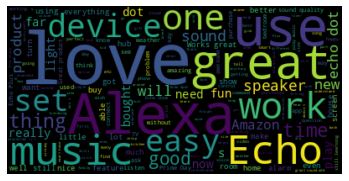

In [ ]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

<ipython-input-68-3c303bced4a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])


In [ ]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)

In [ ]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 443, 120)          60000     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 443, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 176)               209088    
                                                                 
 dense_3 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
69/69 [==============================] - 153s 2s/step - loss: 0.3142 - accuracy: 0.9170
Epoch 2/5
69/69 [==============================] - 147s 2s/step - loss: 0.2435 - accuracy: 0.9238
Epoch 3/5
69/69 [==============================] - 147s 2s/step - loss: 0.1789 - accuracy: 0.9361
Epoch 4/5
69/69 [==============================] - 149s 2s/step - loss: 0.1472 - accuracy: 0.9456
Epoch 5/5
69/69 [==============================] - 147s 2s/step - loss: 0.1191 - accuracy: 0.9556


In [ ]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 9s 288ms/step - loss: 0.2507 - accuracy: 0.9153


[0.2506815195083618, 0.9153439402580261]

In [ ]:
y_test

,0,1
2965,0,1
969,0,1
1385,0,1
1233,0,1
2996,0,1
...,...,...
748,0,1
1192,0,1
662,0,1
480,0,1


**B.2 Observations and Learning:**

In this experiment we have observed and studied Sentiment Analysis using the LSTM model.

**B.3 Conclusion:**

After successfully completing this experiment we are able to:
1. Understand LSTM
2. Design and Implementation Sentiment Analysis using LSTM model
